In [20]:
#User defined variables
my_training_state = 'MN' # should be the postal code abbreviation for the state you created the environmental raster for....
my_nas_id = 5 # go to USGS NAS database for species_ids
my_path = 'data/' + my_training_state + '/'
feature_choices = [
    'Freeze_Up',
    'Ice_Melt',
    'Spawn_Start',
    'Spawn_End',
    'Spawn_Ideal',
    'Ca',
    'pH',
    'DO',
    'Phos',
    'Inv_Algae',
    'Inv_Crustaceans',
    'Inv_Fish',
    'Inv_Mollusks',
    'Inv_Plants',
    'Invasive_Richness',
    'Native_Fish',
    'Precip_Winter',
    'Precip_Spring',
    # 'Precip_Summer',
    # 'Precip_Fall',
    'Flashiness',
    # 'Runoff',
    # 'Drawdown',
    'LST_Annual',
    # 'LST_Summer',
    # 'LST_Winter',
    # 'LST_Spring',
    # 'LST_Fall',
    'NDVI',
    'GPP_Annual',
    # 'GPP_Summer',
    'Heat_Insolation',
    'Topo_Diversity',
    'gHM',
    'NDTI',
    'NDBI',
    'NDCI',
    'NDSI']

In [21]:
#Import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
from functools import reduce
from matplotlib import pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import *
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import json
import requests
import rasterio
from rasterio.features import geometry_mask
from rasterio.sample import sample_gen
from rasterio.mask import mask
import matplotlib.colors as mcolors
from shapely.geometry import mapping
from shapely.geometry import shape
import folium
from folium.plugins import Fullscreen
from rasterio.transform import from_bounds
import seaborn as sns
from shapely.geometry import MultiPolygon
import folium
import matplotlib.pyplot as plt
import branca.colormap as cm
from rasterio.plot import reshape_as_image
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [22]:
# Functions
class Ensemble():
    def __init__(self, models = []):
        self.models = models
        self.accs_dict = None
        self.rocs_dict = None
        self.model_names = [m.__class__.__name__ for m in models]
        self.weights = []
        
    def fit_all(self, X_train, y_train):
        for m in self.models:
            print("Fitting", m.__class__.__name__)
            m.fit(X_train, y_train)
            print(m.__class__.__name__, 'fit.')
        
    
    def evaluate_all(self, X_test, y_true, metric = 'acc'):
        accs = [accuracy_score(y_true, m.predict(X_test)) for m in self.models]
        accs_dict = dict(zip(self.model_names, accs))
        
        
        rocs = [roc_auc_score(y_true, m.predict(X_test)) for m in self.models]
        rocs_dict = dict(zip(self.model_names, rocs))
        
        self.rocs_dict = rocs_dict
        self.accs_dict = accs_dict
        
        if metric == 'acc':
            return accs_dict
        
        return rocs_dict
        
    def get_weights(self):
        return self.rocs_dict
    
    def get_model_names(self):
        return self.model_names
        
# Function that runs the "Drop Column" Feature importance technique 
# I actually have these in a separate .py file which would be much cleaner. 

def make_imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

def drop_col(model, X_train, y_train, random_state = 42):
    #Clone the model
    model_clone = clone(model)
    #Reset random state
    model_clone.random_state = random_state
    #Train and score the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    #Store importances
    importances = []
    
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col,axis=1),y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
        
    importances_df = make_imp_df(X_train.columns, importances)
    return importances_df        
        
def api_call(nas_id, state):
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?species_ID={nas_id}&state={my_training_state}"
    response = requests.get(url_request, timeout=None).json()
    results = pd.json_normalize(response, 'results')
    return results

def sample_multiband_geotiff_with_names(raster_path, gdf):
    """
    Samples a multi-band GeoTIFF at specified point locations from a GeoDataFrame,
    using band names from the raster.

    Parameters:
    - raster_path (str): Path to the GeoTIFF file.
    - gdf (GeoDataFrame): GeoDataFrame containing point geometries.

    Returns:
    - GeoDataFrame with additional columns for each band, using raster band names.
    """

    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Reproject GeoDataFrame to match raster CRS if needed
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Convert point geometries to raster pixel coordinates
        coords = [(geom.x, geom.y) for geom in gdf.geometry]

        # Sample raster at point locations (returns a list of tuples with values per band)
        sampled_values = list(src.sample(coords))

        # Get band names (if available, otherwise use default names)
        band_names = src.descriptions if all(src.descriptions) else [f"band_{i+1}" for i in range(src.count)]

        # Create new columns in the GeoDataFrame with the corresponding band names
        for band_idx, band_name in enumerate(band_names):
            gdf[band_name] = [val[band_idx] for val in sampled_values]

    return gdf

def calculate_metrics_and_plot(conf_matrices):
    sensitivities = []
    specificities = []
    tss_values = []
    
    # Iterate through each confusion matrix
    for cm in conf_matrices:
        TN, FP, FN, TP = cm.ravel()  # Flatten confusion matrix

        sensitivity = TP / (TP + FN)  # Sensitivity (TPR)
        specificity = TN / (TN + FP)  # Specificity (TNR)
        tss = sensitivity + specificity - 1  # True Skill Statistic (TSS)

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        tss_values.append(tss)

    # Compute mean specificity and sensitivity
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    # Plot Boxplot of TSS
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=tss_values, color="skyblue")
    plt.axhline(mean_sensitivity, color="red", linestyle="--", label=f'Mean Sensitivity: {mean_sensitivity:.3f}')
    plt.axhline(mean_specificity, color="green", linestyle="--", label=f'Mean Specificity: {mean_specificity:.3f}')
    plt.ylabel("True Skill Statistic (TSS)")
    plt.title("Boxplot of TSS with Mean Sensitivity & Specificity")
    plt.legend()
    plt.show()

    return sensitivities, specificities, tss_values

def clip_points_with_polygon(points_gdf, polygon_gdf):
    clipped_gdf = points_gdf[points_gdf.geometry.within(polygon_gdf.geometry.union_all())]
    return clipped_gdf

def filter_dataframe_columns(df, feature_choices):
    return df[[col for col in df.columns if col in feature_choices]]

def mark_true(series):
    return [True if feature in series else False for feature in X_train_scaled.columns]

def rename_dict(dictionary, tek_name):
    return_names = []
    return_lists = []
    
    for item in dictionary.items():
        return_names.append(tek_name + str(item[0]))
        return_lists.append(mark_true(list(item[1])))
        
    return dict(zip(return_names, return_lists))
# Function to create empty dictionaries for feature importance
def make_dict():
    return {tup[0]: None for tup in vc_names}

def make_dict_imp():
    return dict(zip([tup[0] for tup in vc_names], [None]))

# Function to append model weights to indv_roc
def append_model_weights(classifiers, X_test_scaled, y_test):
    weights = [accuracy_score(y_test, clf.predict(X_test_scaled)) for clf in classifiers]
    indv_roc.append(weights)
    return weights



In [23]:
pos_data = api_call(my_nas_id, my_training_state)
my_data = pos_data[["decimalLatitude", "decimalLongitude"]]
pos_data_gdf = gpd.GeoDataFrame(
    my_data, geometry=gpd.points_from_xy(my_data.decimalLongitude, my_data.decimalLatitude)).dropna().set_crs(4269)
bg_data_gdf = gpd.read_file(my_path + my_training_state + "_bg.shp").dropna().set_crs(5070, allow_override=True)

In [24]:
# Load the GeoTIFF and GeoDataFrame
raster_path = my_path + my_training_state + "_combined.tif" #If you are training in one state and predicting to another change this to your training state raster filename

# Sample raster at points
pos_data = sample_multiband_geotiff_with_names(raster_path, pos_data_gdf)
neg_data = sample_multiband_geotiff_with_names(raster_path, bg_data_gdf)
# clip the data to your state


In [25]:
# Sample the environmental data at occurence and background locations
my_pos = filter_dataframe_columns(pos_data, feature_choices).dropna().astype(float)
my_negs = filter_dataframe_columns(neg_data, feature_choices).dropna().astype(float)
my_negs = my_negs[(my_negs != 0).any(axis=1)]
my_pos["Present"], my_negs["Present"] = 1.0, 0.0

In [26]:
my_negs.head()

,Ca,pH,DO,Phos,Precip_Winter,Precip_Spring,Flashiness,LST_Annual,NDVI,GPP_Annual,...,Spawn_Start,Freeze_Up,Ice_Melt,Inv_Algae,Inv_Crustaceans,Inv_Fish,Inv_Mollusks,Inv_Plants,Native_Fish,Present
1,31.508646,7.548730,0.500000,0.017747,279.873444,251.857300,0.514929,14820.50,8006.5,262.0,...,64.0,312.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.468676,7.484052,0.500000,0.061042,254.549896,219.320450,0.514929,14819.25,7985.0,220.0,...,64.0,296.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,149.000000,7.924356,0.100000,0.020062,194.877502,166.811401,0.514929,14833.00,8851.5,185.0,...,64.0,296.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,86.699478,8.002353,0.481761,0.190303,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,69.742996,8.098159,1.000000,0.206757,212.043747,148.296005,0.514929,14472.25,8395.0,266.0,...,72.0,320.0,80.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [27]:
my_pos.head()

,Ca,pH,DO,Phos,Precip_Winter,Precip_Spring,Flashiness,LST_Annual,NDVI,GPP_Annual,...,Spawn_Start,Freeze_Up,Ice_Melt,Inv_Algae,Inv_Crustaceans,Inv_Fish,Inv_Mollusks,Inv_Plants,Native_Fish,Present
0,38.153084,7.757396,0.100000,0.069464,280.226288,184.704300,0.514929,14833.50,3918.0,144.5,...,80.0,328.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,14.000000,6.955000,0.700000,0.014000,281.545441,252.441650,0.984732,14671.00,7053.5,406.0,...,64.0,328.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.069451,6.981020,0.416592,0.012248,253.659149,235.939545,0.984732,14619.00,7622.0,688.5,...,72.0,320.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7.246777,7.004810,0.250000,0.011021,274.046600,250.393295,0.514929,14665.50,8394.5,374.0,...,64.0,312.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10.548517,6.687209,0.200000,0.112195,265.537994,226.860046,0.937437,14657.75,8145.5,178.0,...,64.0,312.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


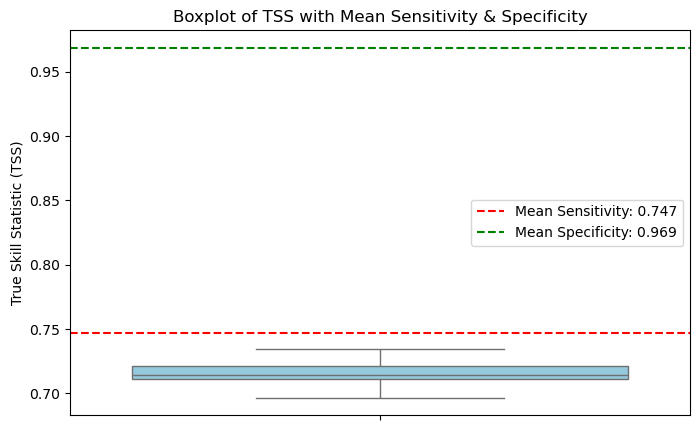

In [28]:
# Train/Test model on training state data and get weights for feature importance analysis.  
indv_roc, vc_roc_arr, vc_cm_arr = [], [], []

for x in range(1, 11): 
    print(f"Iteration {x}")
    
    # Splitting positive and negative samples
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        my_pos.drop(columns=['Present']), my_pos["Present"], test_size=0.25, train_size=0.75, random_state=42)
    
# Adjust negative samples to match the positive sample sizes
    X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
    my_negs.drop(columns=['Present']), my_negs["Present"], train_size=0.50, test_size=0.15, random_state=42)
    
    # Combine training sets
    X_train = pd.concat([X_train_pos, X_train_neg])
    y_train = pd.concat([y_train_pos, y_train_neg])
    
    # Standardizing the data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test = pd.concat([X_test_pos, X_test_neg])
    X_test_scaled = scaler.transform(X_test)
    y_test = pd.concat([y_test_pos, y_test_neg])
    
    # Define classifiers
    MaxEnt = LogisticRegression(max_iter=10000)
    rf = RandomForestClassifier(n_estimators=1000)
    brt = GradientBoostingClassifier(n_estimators=1000)
    dt = DecisionTreeClassifier()
    mlp = MLPClassifier(max_iter=10000)
    
    # Train classifiers
    classifiers = [MaxEnt, rf, dt, brt, mlp]
    for clf in classifiers:
        clf.fit(X_train_scaled, y_train)
    
    # Append individual model weights
    weights = append_model_weights(classifiers, X_test_scaled, y_test)
    indv_roc.append(weights)
    # Ensemble Voting Classifier
    vc_names = [('DT', dt), ('MaxEnt', MaxEnt), ('MLP', mlp), ('BRT', brt), ('RF', rf)]
    vc = VotingClassifier(estimators=vc_names, voting='soft', weights=weights)
    vc.fit(X_train_scaled, y_train)
    
     
    # Performance Metrics
    vc_roc = accuracy_score(y_test, vc.predict(X_test_scaled))
    vc_cm = confusion_matrix(y_test, vc.predict(X_test_scaled))
        
    vc_roc_arr.append(vc_roc)
    vc_cm_arr.append(vc_cm)
        
sensitivities, specificities, tss_values = calculate_metrics_and_plot(vc_cm_arr)

Considering DecisionTreeClassifier()
Considering LogisticRegression(max_iter=10000)
Considering GradientBoostingClassifier(n_estimators=1000)
Considering RandomForestClassifier(n_estimators=1000)
Feature importance evaluation completed.


Text(0, 0.5, 'Number of times a variable appeared in top 3')

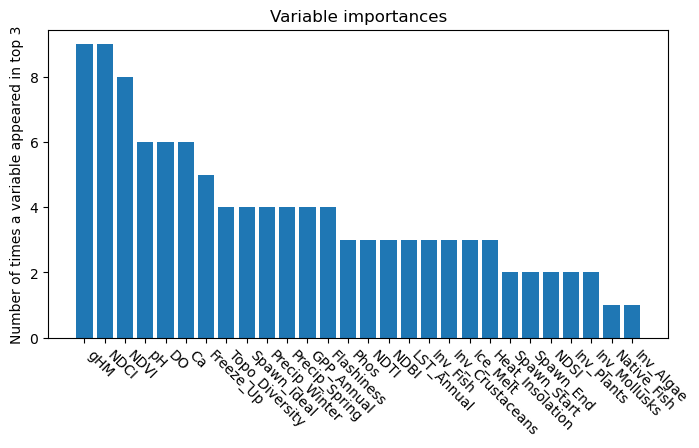

In [29]:
# Calculate predictor importance for training state
avg_weight = [sum(col) / float(len(col)) for col in zip(*indv_roc)]
vc_imp = VotingClassifier(estimators=vc_names, voting='soft', weights=avg_weight)

# Splitting positive and negative samples
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        my_pos.drop(columns=['Present']), my_pos["Present"], test_size=0.25, train_size=0.75, random_state=42)
# Determine the number of training and testing samples for negative data
n_train_pos = len(X_train_pos)
n_test_pos = len(X_test_pos)

# Adjust negative samples to match the positive sample sizes
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
    my_negs.drop(columns=['Present']), my_negs["Present"], train_size=n_train_pos, test_size=n_test_pos, random_state=42)
                  
X_train = pd.concat([X_train_pos, X_train_neg])
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))

y_train = pd.concat([y_train_pos, y_train_neg])

vc_imp.fit(X_train_scaled, y_train)

# Initialize feature importance dictionaries
rfe_dict, perm_dict, drop_dict = make_dict_imp(), make_dict_imp(), make_dict_imp()

for alg in vc_imp.named_estimators:
        dict_name = alg
        clf = vc_imp.named_estimators[dict_name]
        if dict_name == 'MLP':
            continue
        print("Considering", clf)
    
        # Recursive Feature Elimination (RFE)
        rfe_selector = RFECV(estimator=clf, min_features_to_select=3, step=1)
        rfe_selector.fit(X_train_scaled, y_train)
        rfe_support = rfe_selector.get_support()
        rfe_features = X_train_scaled.loc[:,rfe_support].columns.tolist()
        rfe_dict[dict_name] = rfe_features
        # Permutation Importance
        perm_imp = permutation_importance(clf, X_train_scaled, y_train)
        perm_imp['feature'] = X_train_scaled.columns
        perm_features = pd.DataFrame(perm_imp['feature'],perm_imp['importances_mean'],columns = ['Feature']) \
                        .sort_index(ascending=False)['Feature'].values[:3]
        perm_dict[dict_name] = perm_features
        # Drop Column Importance (Assuming a predefined drop_col function)
        drop_dict_list = []
        
        drop_col_feats = drop_col(clf, X_train_scaled, y_train) #, random_state = 10)
        drop_col_three = drop_col_feats.sort_values('feature_importance',ascending = False)['feature'][:3]
        drop_dict[dict_name] = drop_col_three
    
print("Feature importance evaluation completed.")


#We end up with a dataframe that says, for any model / feature importance technique, whether or not a feature ended up in the top N (i.e. whether or not that feature is important).
features_df = pd.concat([pd.DataFrame(rename_dict(perm_dict,'PERM_')).reset_index(drop=True),
                        pd.DataFrame(rename_dict(rfe_dict,'RFE_')),
                        pd.DataFrame(rename_dict(drop_dict, 'DROP_'))],axis=1)

features_df['Total'] = np.sum(features_df, axis=1)
features_df['Feature'] = X_train.columns
features_df.sort_values(['Total','Feature'] , ascending=False,inplace=True)
fig, ax = plt.subplots(figsize=(8,4))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )

# plt.xticks(rotation=75)
plt.bar(features_df['Feature'], features_df['Total'])
plt.title("Variable importances")
plt.ylabel("Number of times a variable appeared in top 3")

In [30]:
# Create heatmap with all data
X_train_pos = my_pos.drop(columns=['Present'])
y_train_pos = my_pos['Present']

neg_sample, _ = train_test_split(my_negs, train_size=.5, random_state=42)
X_train_neg = neg_sample.drop(columns=['Present'])
y_train_neg = neg_sample['Present']

X_train = pd.concat([X_train_pos, X_train_neg])
scaler_heatmap = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler_heatmap.transform(X_train), columns=X_train.columns)

y_train = pd.concat([y_train_pos, y_train_neg])

MaxEnt = LogisticRegression(max_iter = 10000)
rf = RandomForestClassifier(n_estimators=1000)
brt = GradientBoostingClassifier(n_estimators=1000)
dt = DecisionTreeClassifier()
mlp = MLPClassifier(max_iter = 10000)

# Individual Confusion Matrices
MaxEnt.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled,y_train)
dt.fit(X_train_scaled, y_train)
brt.fit(X_train_scaled, y_train) 
mlp.fit(X_train_scaled, y_train)                    
########################################################################################################
#Ensemble 
ensemble_vc = Ensemble([dt, MaxEnt, rf, brt, mlp]) 
ensemble_vc.fit_all(X_train_scaled, y_train)
weights = ensemble_vc.get_weights()
vc_names = [('DT', dt), ('MaxEnt', MaxEnt), ('MLP', mlp), ('BRT', brt), ('RF', rf)]
vc_heatmaps = VotingClassifier(estimators=vc_names, voting='soft', weights = weights)
vc_heatmaps.fit(X_train_scaled, y_train)


Fitting DecisionTreeClassifier
DecisionTreeClassifier fit.
Fitting LogisticRegression
LogisticRegression fit.
Fitting RandomForestClassifier
RandomForestClassifier fit.
Fitting GradientBoostingClassifier
GradientBoostingClassifier fit.
Fitting MLPClassifier
MLPClassifier fit.


VotingClassifier(estimators=[('DT', DecisionTreeClassifier()),
                             ('MaxEnt', LogisticRegression(max_iter=10000)),
                             ('MLP', MLPClassifier(max_iter=10000)),
                             ('BRT',
                              GradientBoostingClassifier(n_estimators=1000)),
                             ('RF', RandomForestClassifier(n_estimators=1000))],
                 voting='soft')

In [31]:
def predict_raster_and_export(model, scaler, input_raster, output_raster, feature_list, state_polygon):
    """
    Predicts species presence probability from a raster using a trained model and exports the result.
    
    Parameters:
    - model: Trained machine learning model (supports predict_proba)
    - scaler: StandardScaler fitted to training data
    - input_raster: Path to input raster file
    - output_raster: Path to save predicted probability raster
    - feature_list: List of selected feature names (matching band names in the raster)
    - state_polygon: GeoDataFrame containing the state boundary
    """
    # Open the raster file
    with rasterio.open(input_raster) as src:
        profile = src.profile  # Get metadata
        band_names = src.descriptions  # Band names in the raster

        if band_names is None:
            raise ValueError("Raster bands are missing names. Ensure input raster has band descriptions.")

        # Select only the bands that were used in training
        selected_bands_indices = [i for i, band in enumerate(band_names) if band in feature_list]

        if not selected_bands_indices:
            raise ValueError("No matching bands found in the raster for the provided feature list.")

        # Mask raster to the state polygon
        state_geom = [shape(state_polygon.geometry.iloc[0])]
        img_data, transform = mask(src, state_geom, crop=True, nodata=np.nan)

        # Read only the selected bands
        img_data = img_data.astype(float)
        img_data = img_data[selected_bands_indices, :, :]

        # Reshape to 2D (pixels as rows, bands as columns)
        num_bands = len(selected_bands_indices)
        num_pixels = img_data.shape[1] * img_data.shape[2]
        img_reshaped = img_data.reshape(num_bands, num_pixels).T

        # Remove NaN values
        valid_mask = ~np.isnan(img_reshaped).any(axis=1)
        valid_pixels = img_reshaped[valid_mask]

        # Convert to DataFrame with correct feature names
        valid_pixels_df = pd.DataFrame(valid_pixels, columns=[feature_list[i] for i in range(len(selected_bands_indices))])

        # Ensure valid_pixels_scaled remains a DataFrame with correct feature names
        valid_pixels_scaled = pd.DataFrame(scaler.transform(valid_pixels_df), columns=feature_list)
        
        # Predict probability of presence
        predicted_probs = model.predict_proba(valid_pixels_scaled)[:, 1]

        # Create an empty array for the full image, setting invalid pixels to NaN
        predicted_raster = np.full(img_reshaped.shape[0], np.nan)
        predicted_raster[valid_mask] = predicted_probs

        # Reshape back to original raster shape
        predicted_raster = predicted_raster.reshape(img_data.shape[1], img_data.shape[2])

        # Update metadata for a single-band float output raster
        profile.update(dtype=rasterio.float32, count=1, compress='lzw')

        # Write the predicted probability raster to a new file
        with rasterio.open(output_raster, 'w', **profile) as dst:
            dst.write(predicted_raster.astype(rasterio.float32), 1)
    
    print(f"Predicted raster saved to: {output_raster}")


In [35]:
output_tif = "predicted_probabilities.tif"
state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().to_crs(5070)
state_polygon = state_boundary[state_boundary['STUSPS'] == my_training_state]
feature_list = X_train.columns
predict_raster = raster_path #"data/WA/WA_combined.tif"
m = predict_raster_and_export(vc_heatmaps, scaler_heatmap, predict_raster, output_tif, feature_list, state_polygon)

Predicted raster saved to: predicted_probabilities.tif


In [36]:
def display_prediction_folium(raster_path):
    """
    Opens a saved prediction raster, converts it to EPSG:4326 if needed, 
    and displays it as an interactive Folium map using the Jet colormap.

    Parameters:
    - raster_path (str): Path to the predicted probability raster file (GeoTIFF).

    Returns:
    - folium.Map: Folium map object displaying the raster.
    """
    with rasterio.open(raster_path) as src:
        transform = src.transform
        original_crs = src.crs  # Get original CRS
        raster_data = src.read(1).astype(float)  # Read first band as float
        nodata_value = src.nodata  # Get NoData value

        # Handle NaN or NoData values
        if nodata_value is not None:
            raster_data[raster_data == nodata_value] = np.nan  # Convert NoData to NaN

    # Convert raster to EPSG:4326 if needed
    if original_crs != "EPSG:4326":
        dst_crs = "EPSG:4326"

        # Calculate new transform and dimensions
        transform, width, height = calculate_default_transform(
            original_crs, dst_crs, src.width, src.height, *src.bounds
        )

        # Create empty array for reprojected data
        dst_data = np.empty((height, width), dtype=np.float32)

        # Reproject raster to EPSG:4326
        with rasterio.open(raster_path) as src:
            reproject(
                source=raster_data,
                destination=dst_data,
                src_transform=src.transform,
                src_crs=original_crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

        raster_data = dst_data  # Update with reprojected data
    else:
        transform = src.transform  # Keep original if already in EPSG:4326

    # Get raster bounds in correct order for Folium
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(raster_data.shape[0], raster_data.shape[1], transform)

    # Normalize raster values for visualization
    raster_min, raster_max = np.nanmin(raster_data), np.nanmax(raster_data)
    if raster_max == raster_min:
        print("Warning: Raster contains uniform values. Adjusting visualization.")
        normed_raster = np.zeros_like(raster_data)  # Avoid divide by zero
    else:
        normed_raster = (raster_data - raster_min) / (raster_max - raster_min)

    # Apply 'jet' colormap
    cmap = plt.get_cmap("jet")
    heatmap_image = (cmap(normed_raster)[:, :, :3] * 255).astype(np.uint8)  # Convert to 8-bit RGB

    # Create a Folium map centered on the raster
    m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=6)

    # Overlay raster on map
    folium.raster_layers.ImageOverlay(
        image=heatmap_image,
        bounds=[[miny, minx], [maxy, maxx]],  # Ensure correct order for folium
        opacity=0.7,
    ).add_to(m)

    # Add colorbar
    colormap = cm.LinearColormap(
        colors=['blue', 'cyan', 'green', 'yellow', 'red'],
        vmin=raster_min, vmax=raster_max,
        caption="Species Presence Probability"
    )
    m.add_child(colormap)

    return m



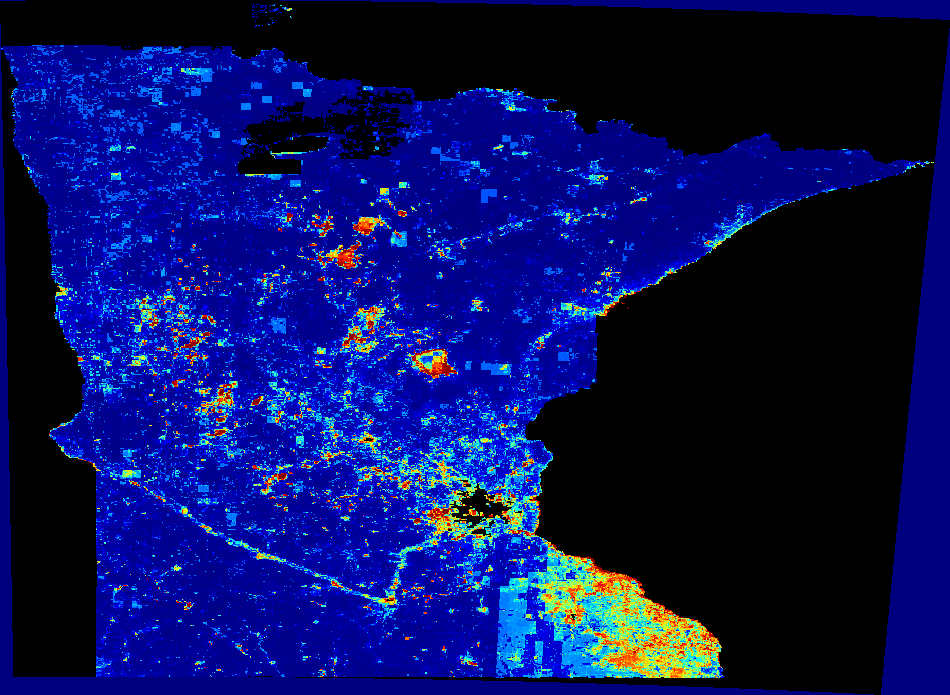

In [37]:
m = display_prediction_folium("predicted_probabilities.tif")
m #.save("prediction_map.html")  # Save as an interactive HTML file